In [1]:
#Import Packages
from unityagents import UnityEnvironment
from agent import Agent

from collections import deque

import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#Load Envrionment
env = UnityEnvironment(file_name='Tennis_Windows_x86_64/Tennis.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
#Set default brain (actions)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
#Reset the environment
env_info = env.reset(train_mode=True)[brain_name]

#Number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

#Size of actions
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

#Examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('State size: {}'.format(state_size))

Number of agents: 2
Size of each action: 2
State size: 24


In [5]:
#Load Agent
agent = Agent(state_size=24, action_size=2, n_agents=2, random_seed=10)

GPU: True


In [6]:
#Visual Presentation
def plot_scores(scores, episode, rolling_window=10, save_fig=False):
    """Plot scores and optional rolling mean using specified window."""
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title("Episode: {}".format(episode))
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    plt.show()

    if save_fig:
        plt.savefig(f'figures_scores.png', bbox_inches='tight', pad_inches=0)

Episode 250	Average Score: 0.00

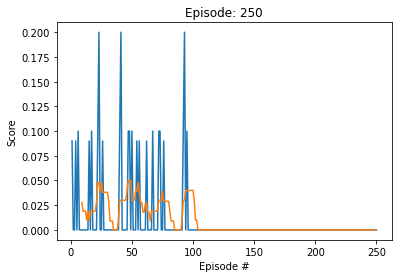

Episode 500	Average Score: 0.00

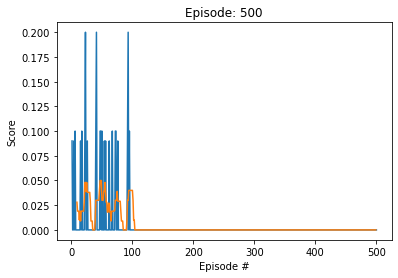

Episode 750	Average Score: 0.00

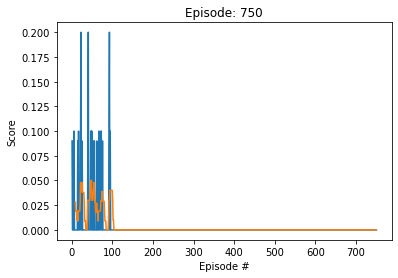

Episode 1000	Average Score: 0.00

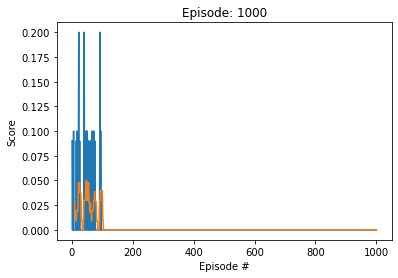

Episode 1250	Average Score: 0.00

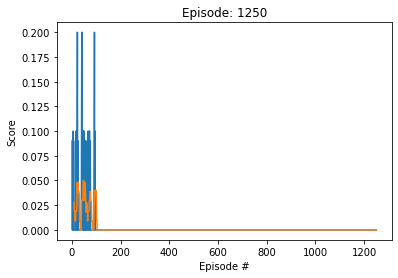

Episode 1500	Average Score: 0.00

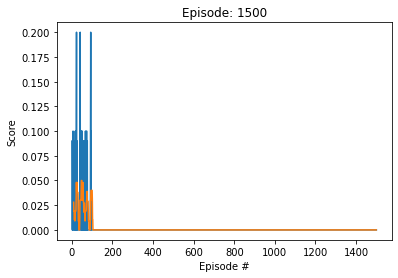

Episode 1750	Average Score: 0.00

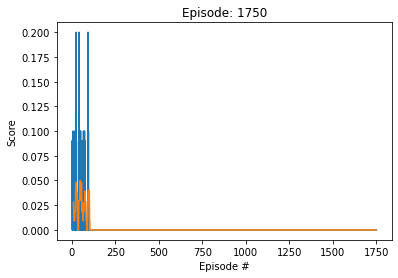

Episode 2000	Average Score: 0.00

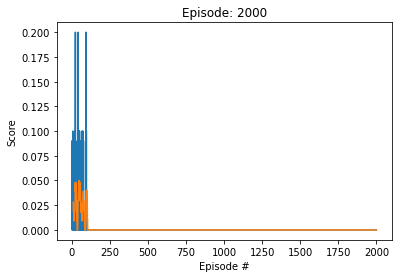

Episode 2250	Average Score: 0.00

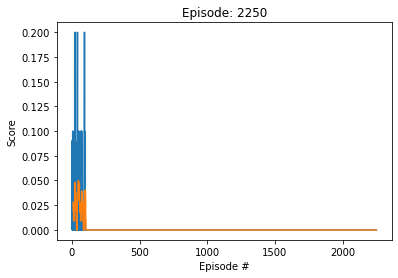

Episode 2500	Average Score: 0.00

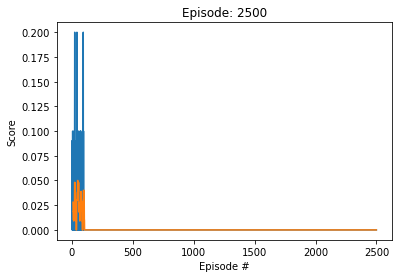

Episode 2750	Average Score: 0.00

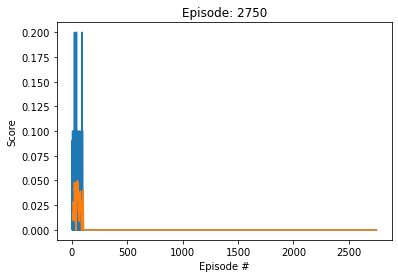

Episode 3000	Average Score: 0.00

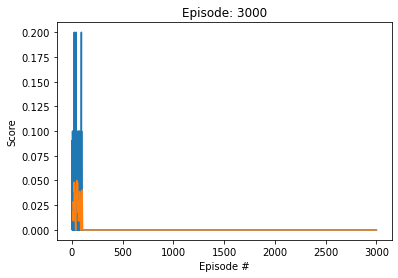

Episode 3250	Average Score: 0.00

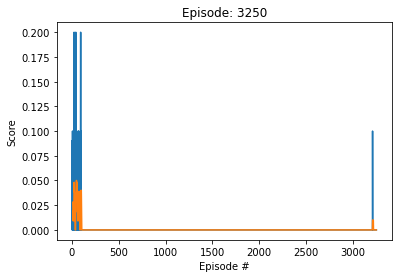

Episode 3500	Average Score: 0.00

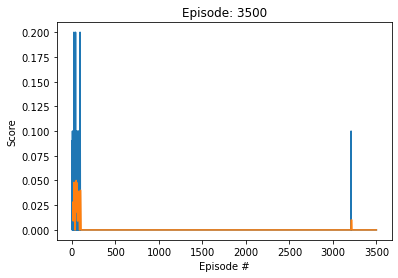

Episode 3750	Average Score: 0.00

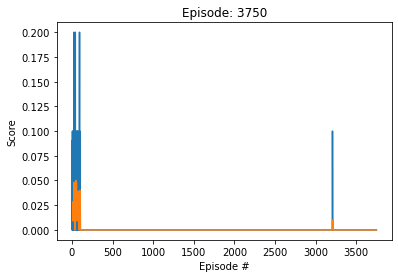

Episode 4000	Average Score: 0.00

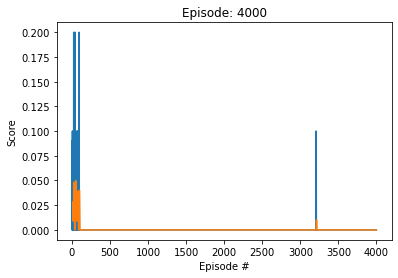

Episode 4250	Average Score: 0.04

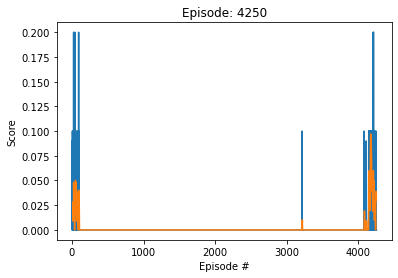

Episode 4500	Average Score: 0.00

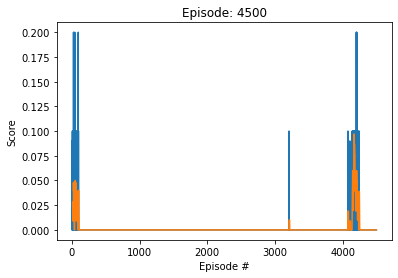

Episode 4750	Average Score: 0.00

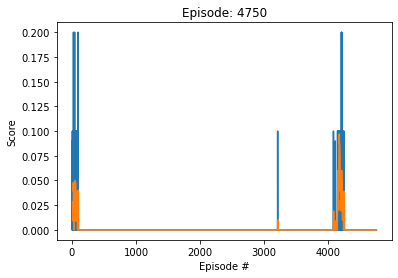

Episode 5000	Average Score: 0.00

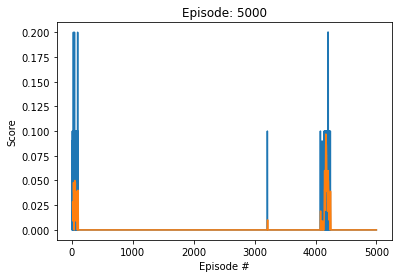

Episode 5250	Average Score: 0.00

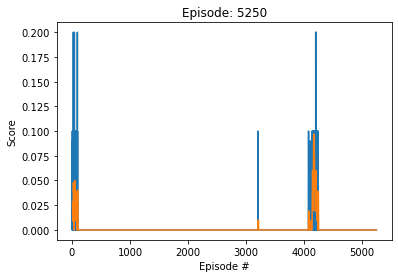

Episode 5500	Average Score: 0.00

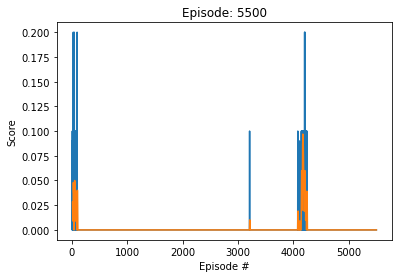

Episode 5750	Average Score: 0.00

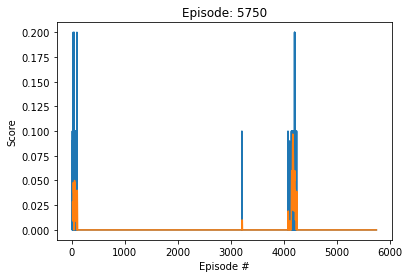

Episode 6000	Average Score: 0.00

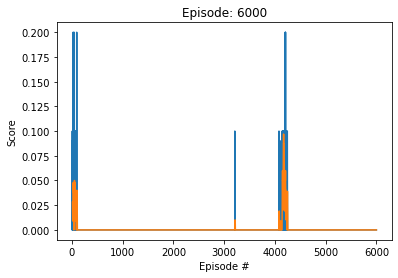

Episode 6250	Average Score: 0.00

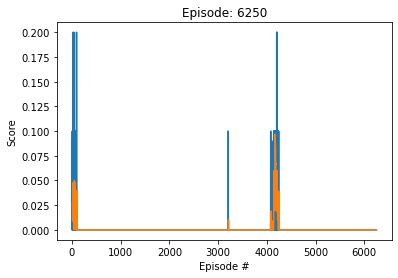

Episode 6500	Average Score: 0.00

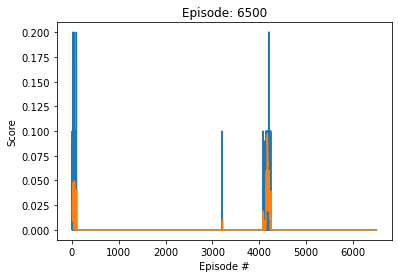

Episode 6750	Average Score: 0.00

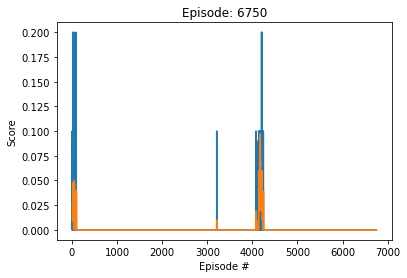

Episode 7000	Average Score: 0.00

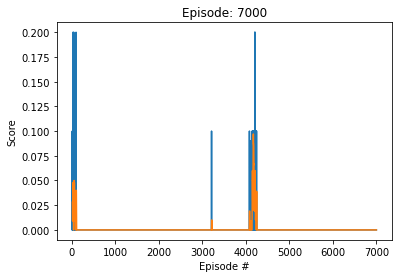

Episode 7250	Average Score: 0.00

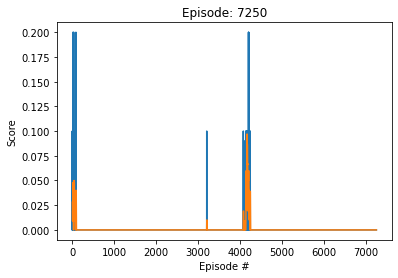

Episode 7500	Average Score: 0.00

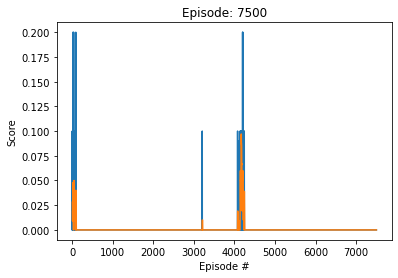

Episode 7586	Average Score: 0.00

KeyboardInterrupt: 

In [7]:
def maddpg(n_episodes=10000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations  #get the current agent state
        game_scores = np.zeros(2)  #the scores of an episode for both agents
        
        agent.reset()
        
        noise = 1.
        
        for t in range(max_t):
            
            if i_episode < 100:
                actions = np.random.randn(2, 2) #use random actions for the first 100 episodes, helps with exploration
            else:
                actions = agent.act(states, noise=noise) #let the agent select actions, continues with exploitation
                
            actions_player2 = np.flip(actions, 0) #The actions of the second agent
            
            env_info = env.step(actions)[brain_name]            #execute the selected actions and store the new information
            rewards = env_info.rewards                          #get the rewards
            next_states = env_info.vector_observations          #get the next states
            next_states_player2 = np.flip(next_states, 0)       #get the next states for the second agent
            dones = env_info.local_done                         #check whether episodes have finished
            
            agent.step(states, actions, actions_player2, rewards, next_states, next_states_player2, dones, t)  #pass the information to the agent
            
            states = next_states
            game_scores += rewards
            
            if any(dones):
                break
        
        noise = max(0.999 * noise, 0.01)  # reduce the noise a bit while training
        max_score = np.max(game_scores)  #the max score of the agents
        scores_deque.append(max_score)
        scores.append(max_score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % 250 == 0:
            plot_scores(scores, i_episode)
            
        if i_episode % 2000 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

        if np.mean(scores_deque) > 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            plot_scores(scores, i_episode, save_fig=True)
            
            torch.save(agent.actor_local.state_dict(), 'final_weights/checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'final_weights/checkpoint_critic.pth')
            break

    return scores

scores = maddpg()

In [ ]:
env.close()